In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
df= pd.read_csv('https://raw.githubusercontent.com/data-bootcamp-v4/data/main/file1.csv')

In [3]:
column_names = df.columns
df.shape

(4008, 11)

In [31]:
def cleaning(df):
    cols = []
    for colname in df.columns:
        cols.append(colname.lower())
    df.columns = cols
    df.columns = df.columns.str.replace(' ', '_')
    df.rename(columns={'st': 'state'}, inplace=True)
    duplicates = df.duplicated()
    df= df.drop_duplicates(keep='first') #to not lose more data, I prefer to keep the first duplicate.
    df = df.reset_index(drop=True)
    char_to_replace = {"femal": 'F', 'male': 'M', "female": "F", "Fe": "F", "Fmal": "F", "Male": "M"}
    for key, value in char_to_replace.items():
        df['gender'] = df['gender'].str.replace(key, value)
    state_mapping = {'AZ': 'Arizona','Californiaforniaforniaforniafornia': 'California',  'Californiaforniaforniaforniaforniafornia': 'California', 'Cali': 'California', 'Californiafornia': 'California', 'WA': 'Washington'}
    for key, value in state_mapping.items():
        df['state'] = df['state'].str.replace(key, value)
    # Clean education column
    df['education'].value_counts()
    df["education"] = df['education'].str.replace("Bachelors", "Bachelor")
    # Clean Customer Lifetime Value column
    df['customer_lifetime_value'] = df['customer_lifetime_value'].str.rstrip('%')
    # Clean Vehicle Class column
    vehicle_class_mapping = {'Sports Car': 'Luxury', 'Luxury SUV': 'Luxury', 'Luxury Car': 'Luxury'}
    # Iterate over all key-value pairs in dictionary 
    for key, value in vehicle_class_mapping.items():
        # Replace key character with value character in string
        df['vehicle_class'] = df['vehicle_class'].str.replace(key, value)
    # Customer lifetime value should be numeric
    df['customer_lifetime_value'] = pd.to_numeric(df['customer_lifetime_value'], errors='coerce')
    df['customer_lifetime_value'] = df['customer_lifetime_value'].astype(float)
    # Number of open complaints has an incorrect format.
    # df["number_of_open_complaints"].value_counts()
    ### Extract the number of open complaints from each entry and calculate the middle value###
    df['number_of_open_complaints'] = df['number_of_open_complaints'].str.split('/').str[1]
    #### Cast the column to the proper numeric type###
    df['number_of_open_complaints'] = pd.to_numeric(df['number_of_open_complaints'], errors='coerce')
    df['number_of_open_complaints'] = df['number_of_open_complaints'].astype(float).round(decimals = 2)
    ### Identify columns with null values and calculate the number of null values
    df.isna().sum()
    round(df.isna().sum()/len(df),4)*100  # shows the percentage of null values in a column
    nulls_df = pd.DataFrame(round(df.isna().sum()/len(df),4)*100)
    nulls_df
    nulls_df = nulls_df.reset_index()
    nulls_df
    nulls_df.columns = ['header_name', 'percent_nulls']
    nulls_df
    # Fill null values with column mean for numerical variables
    column_categorical=["state", "gender", "education", "policy_type", "vehicle_class"]
    column_numerical=["income", "monthly_premium_auto", "total_claim_amount", "customer_lifetime_value", "number_of_open_complaints"]
    numerical_columns = df.select_dtypes(include=['number']).columns
    df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())
    categorical_columns = df.select_dtypes(include=['object']).columns
    df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])
    #df.isna().sum()
    #Save the cleaned dataset to a new CSV file
    df.to_csv('cleaned_dataset.csv', index=False)
    return df


print("Cleaned DataFrame:")
cleaning(df)

Cleaned DataFrame:


0       1/0/00
1       1/0/00
2       1/0/00
3       1/0/00
4       1/0/00
         ...  
4003       NaN
4004       NaN
4005       NaN
4006       NaN
4007       NaN
Name: number_of_open_complaints, Length: 4008, dtype: object

In [30]:
column_categorical=["state", "gender", "education", "policy_type", "vehicle_class"]
column_numerical=["income", "monthly_premium_auto", "total_claim_amount", "customer_lifetime_value", "number_of_open_complaints"]
summary = df.describe().T
def roundforme(x):
    return round(x,2)

summary['mean'] = list(map(roundforme, summary['mean']))

# summary
for col in summary.columns:
    summary[col] = summary[col].apply(lambda x : round(x, 2))
summary

KeyError: "None of [Index(['income', 'monthly_premium_auto', 'total_claim_amount',\n       'customer_lifetime_value', 'number_of_open_complaints'],\n      dtype='object')] are in the [columns]"

In [6]:
df['monthly_premium_auto'].unique()
for i, x in enumerate(df['monthly_premium_auto']):
    if x > 400:
        df.at[i, 'monthly_premium_auto'] =193.23436
df['monthly_premium_auto'].unique()

array([193.23436,  94.     , 108.     , 106.     ,  68.     ,  69.     ,
        67.     , 101.     ,  71.     ,  93.     , 110.     ,  70.     ,
        64.     ,  72.     ,  74.     ,  79.     ,  73.     ,  61.     ,
       111.     ,  80.     ,  63.     , 237.     ,  65.     , 130.     ,
        62.     , 117.     ,  91.     ,  90.     ,  66.     ,  99.     ,
       103.     , 172.     ,  92.     , 104.     , 113.     , 124.     ,
       105.     , 100.     , 112.     ,  97.     ,  95.     , 102.     ,
        96.     , 186.     ,  77.     ,  76.     , 119.     ,  87.     ,
       109.     , 107.     ,  88.     ,  85.     , 133.     ,  86.     ,
        78.     ,  89.     , 192.     , 118.     , 140.     , 127.     ,
       126.     ,  82.     , 115.     , 217.     , 114.     , 138.     ,
        81.     , 255.     , 150.     , 123.     , 116.     , 190.     ,
        98.     , 159.     ,  84.     ,  83.     , 152.     , 136.     ,
       245.     , 135.     , 225.     , 132.     , 

In [7]:
df.describe(include='object').T

,count,unique,top,freq
customer,1071,1071,RB50392,1
state,1071,8,Oregon,320
gender,954,5,F,457
education,1071,6,Bachelor,324
customer_lifetime_value,1068,1027,445811.34%,4
number_of_open_complaints,1071,6,1/0/00,830
policy_type,1071,3,Personal Auto,780
vehicle_class,1071,6,Four-Door Car,576


In [8]:
import scipy.stats as stats

In [9]:
df['gender'].value_counts()

gender
F         457
M         413
Male       39
female     28
Femal      17
Name: count, dtype: int64

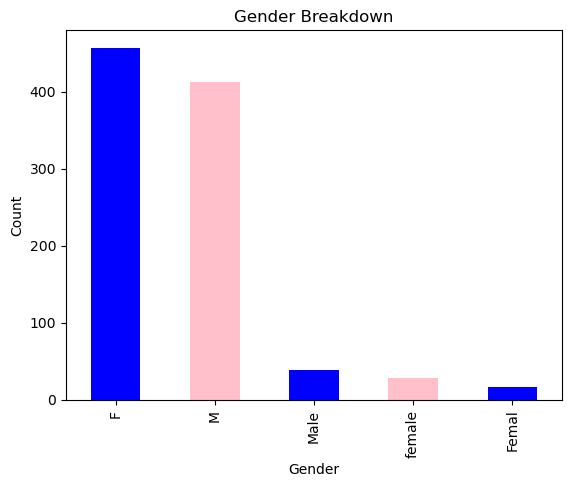

In [10]:
#!pip3 install seaborn if you need to
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
# Task 3: Show a plot of the Gender breakdown
gender_counts = df['gender'].value_counts()
gender_counts.plot(kind='bar', color=['blue', 'pink'])
plt.title('Gender Breakdown')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()
#The number of females is higher than males with over 620 F comparing to 452 M

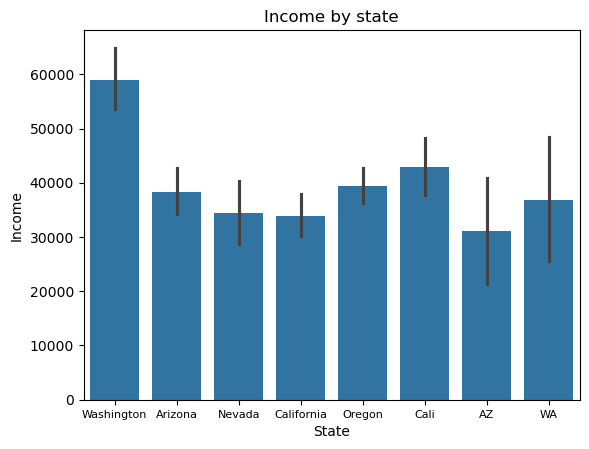

In [11]:
# everything can be a bar chart, but that is a sad sad world
sns.barplot(x="state", y="income", data=df)

# Adjust the font size of the state value labels
plt.xticks(fontsize=8) 
plt.title('Income by state')
plt.xlabel('State')
plt.ylabel('Income')
plt.show()
# individuals in Washington make more income than any other place while Nevada makes the least 

In [12]:
df['state'].value_counts()

state
Oregon        320
California    211
Arizona       186
Cali          120
Nevada         98
Washington     81
WA             30
AZ             25
Name: count, dtype: int64

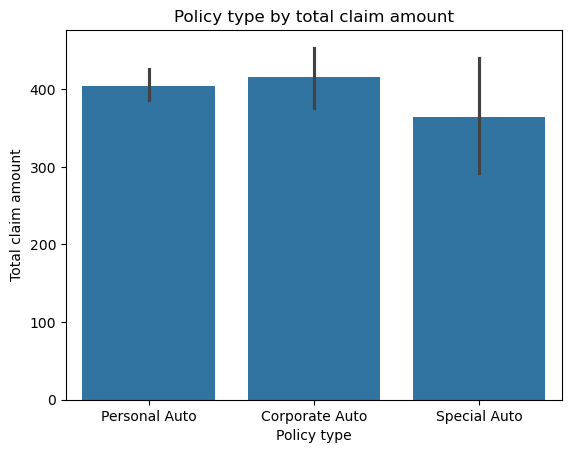

In [13]:
# everything can be a bar chart, but that is a sad sad world
sns.barplot(x="policy_type", y="total_claim_amount", data=df)

# Adjust the font size of the state value labels
plt.xticks(fontsize=10) 
plt.title('Policy type by total claim amount')
plt.xlabel('Policy type')
plt.ylabel('Total claim amount')
plt.show()
 # People with corporate autos have total claim the most and spacial autos has the least

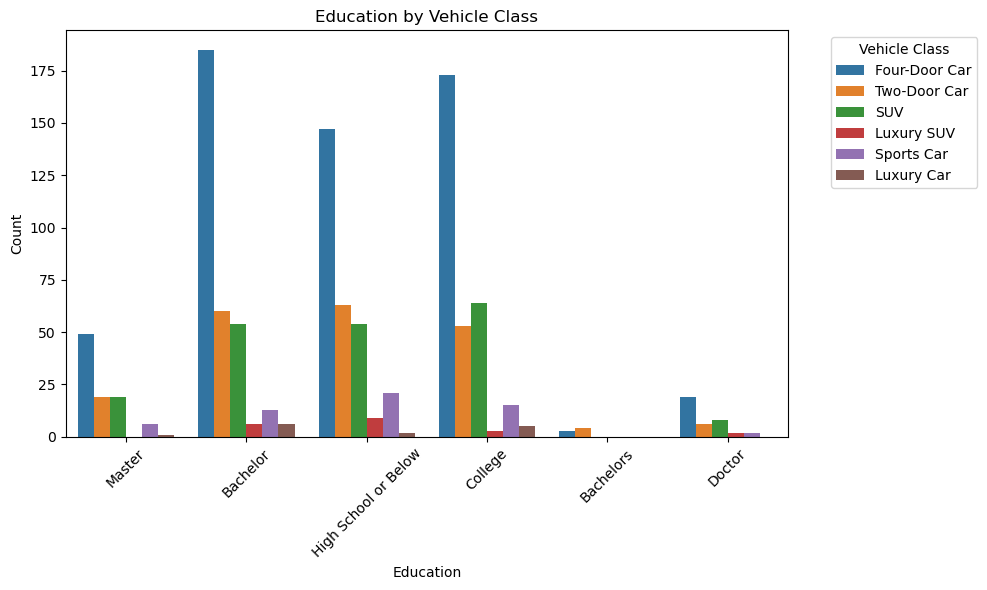

In [14]:
# Create the count plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.countplot(x="education", hue="vehicle_class", data=df)
plt.title('Education by Vehicle Class')
plt.xlabel('Education')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.legend(title='Vehicle Class', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

#the majority of individuals no mater their education level have four-door cars with the people who have a Bachelor degrees score 
# the highest at over 175 and people with a doctoral degree score the least at 20. While luxury cars are hard to get for all groups of 
# different educational levels.

In [15]:
#What other plots do you feel would be beneficial?
# state vs total_claim_amount to see which states are complaining the most
# education vs income to see which groups make more income
# gender vs income to look at the income gap
# gender vs vehicle_class to see the gap 
# gender vs total_claim_amount to see which gender is complaining the most

In [16]:
numerical = df.select_dtypes(include=np.number)
categorical = df.select_dtypes(include=object)

In [17]:
numerical.columns

Index(['income', 'monthly_premium_auto', 'total_claim_amount'], dtype='object')

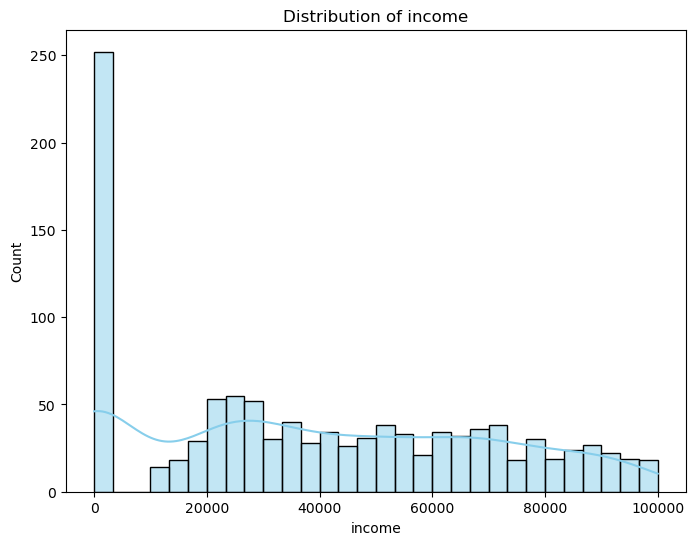

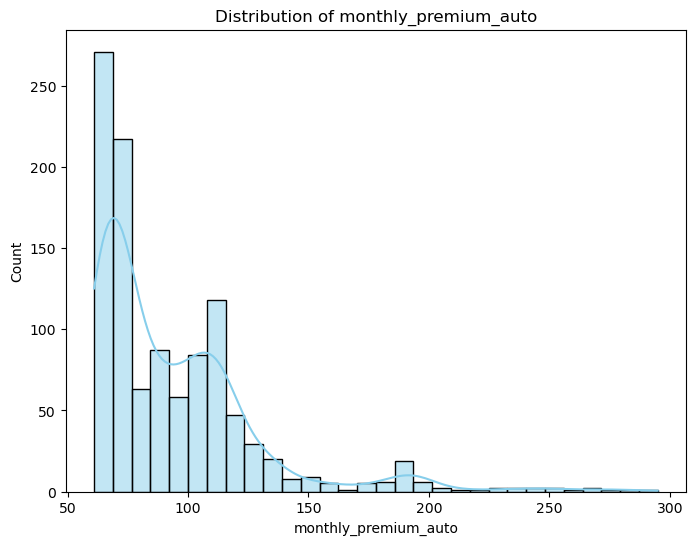

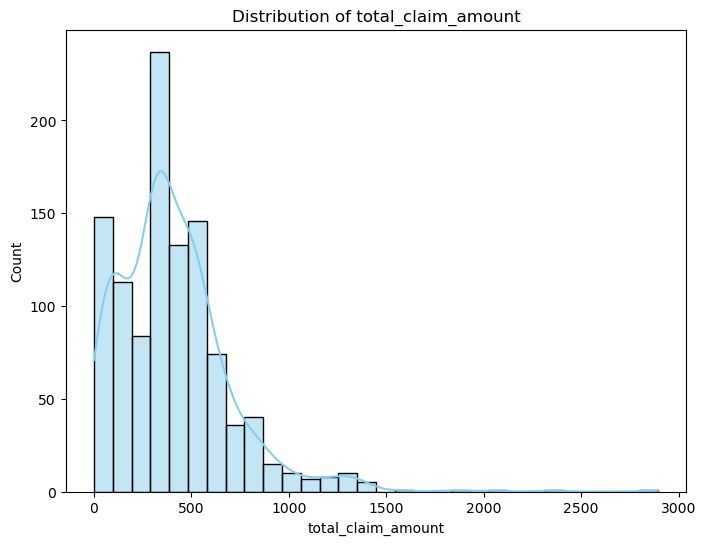

In [18]:
for var in numerical:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=var, kde=True, color='skyblue', bins=30)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.show()

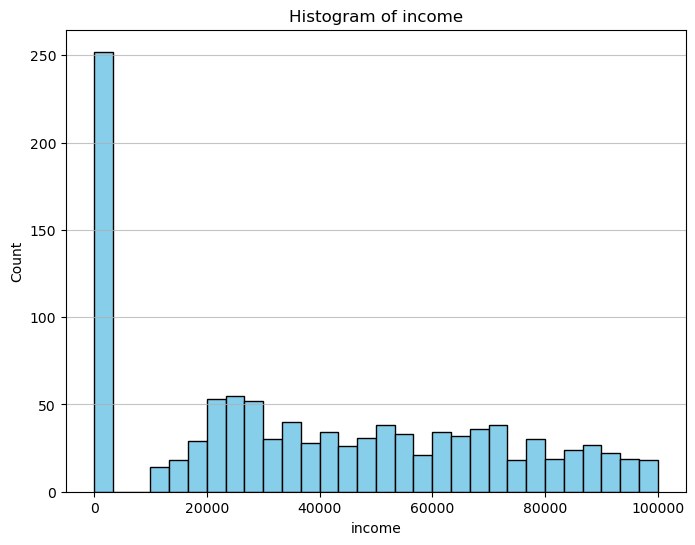

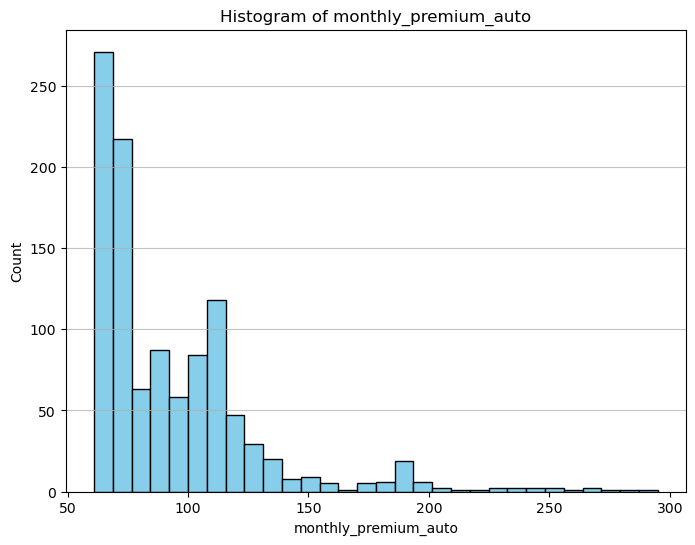

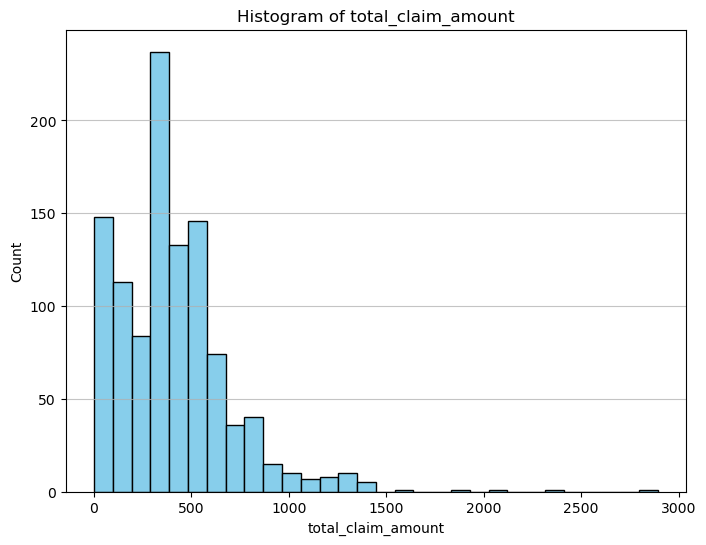

In [19]:
for var in numerical:
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    plt.hist(df[var], bins=30, color='skyblue', edgecolor='black')  
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

==> Total claim amounts + monthly premium auto looks like normal distribution skewed to the right

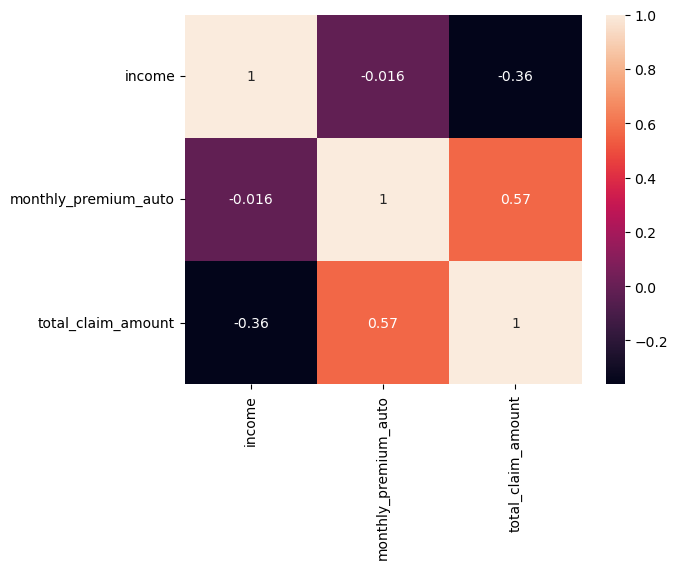

In [20]:
correlations_matrix = numerical.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

==> it looks fine to me


In [21]:
y = df['total_claim_amount']
X = df.drop(['total_claim_amount'], axis=1)

X_num = df.select_dtypes(include = np.number)
X_cat = df.select_dtypes(include = object)

In [22]:
X_num

,income,monthly_premium_auto,total_claim_amount
0,0.0,193.23436,2.704934
1,0.0,94.00000,1131.464935
2,48767.0,108.00000,566.472247
3,0.0,106.00000,529.881344
4,36357.0,68.00000,17.269323
...,...,...,...
4003,NaN,NaN,NaN
4004,NaN,NaN,NaN
4005,NaN,NaN,NaN
4006,NaN,NaN,NaN


In [27]:
X_cat
X_cat.drop(columns="customer", inplace=True)

,state,gender,education,customer_lifetime_value,number_of_open_complaints,policy_type,vehicle_class
0,Washington,NaN,Master,NaN,1/0/00,Personal Auto,Four-Door Car
1,Arizona,F,Bachelor,697953.59%,1/0/00,Personal Auto,Four-Door Car
2,Nevada,F,Bachelor,1288743.17%,1/0/00,Personal Auto,Two-Door Car
3,California,M,Bachelor,764586.18%,1/0/00,Corporate Auto,SUV
4,Washington,M,High School or Below,536307.65%,1/0/00,Personal Auto,Four-Door Car
...,...,...,...,...,...,...,...
4003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4006,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
X_cat = X_cat.reset_index(drop=True)

In [25]:
# scaling standard scaler: make data distributed with mean=0 and std=1
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(X_num)
X_standardized = transformer.transform(X_num)
print(X_standardized.shape)
X_standardized = pd.DataFrame(X_standardized,columns=X_num.columns)

(4008, 3)


In [26]:
#one hot encoding is a way to turn categorical variables into multiple numerical columns
encoder = OneHotEncoder(drop='first').fit(X_cat)
print(encoder.categories_)
encoded = encoder.transform(X_cat).toarray()
print(encoded)
onehot_encoded = pd.DataFrame(encoded,columns=['California', 'Nevada', 'Oregon', 'Washington', 'M', 'College', 'Doctor', 'High School or Below', 'Master', 'Personal Auto', 'Special Auto', 'Luxury', 'SUV', 'Two-Door Car'])
onehot_encoded.head(20)


[array(['AZ', 'Arizona', 'Cali', 'California', 'Nevada', 'Oregon', 'WA',
       'Washington', nan], dtype=object), array(['F', 'Femal', 'M', 'Male', 'female', nan], dtype=object), array(['Bachelor', 'Bachelors', 'College', 'Doctor',
       'High School or Below', 'Master', nan], dtype=object), array(['1006460.83%', '1011077.82%', '1011544.62%', ..., '994230.48%',
       '995170.77%', nan], dtype=object), array(['1/0/00', '1/1/00', '1/2/00', '1/3/00', '1/4/00', '1/5/00', nan],
      dtype=object), array(['Corporate Auto', 'Personal Auto', 'Special Auto', nan],
      dtype=object), array(['Four-Door Car', 'Luxury Car', 'Luxury SUV', 'SUV', 'Sports Car',
       'Two-Door Car', nan], dtype=object)]
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


ValueError: Shape of passed values is (4008, 1061), indices imply (4008, 14)

In [ ]:
# let's merge all this information together into a single dataset with all features
X1 = pd.concat([X_standardized, onehot_encoded ], axis=1)  # np.concatenate()
X1

In [ ]:
X= X1.drop(['total_claim_amount'], axis=1)
y = X1['total_claim_amount']
y.head()
# train test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
#we train/fit our model 
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)

In [ ]:
predictions = lm.predict(X_train)
r2_score(y_train, predictions)

In [ ]:
predictions_test = lm.predict(X_test)
r2_score(y_test, predictions_test)

In [ ]:
mse=mean_squared_error(y_test,predictions_test)
mse

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test,predictions_test))
rmse
rmse = math.sqrt(mse)
rmse

In [ ]:
mae = mean_absolute_error(y_test, predictions_test)
print(mae)

In [ ]:
lm.score(X_test, y_test)

In [ ]:
r2 = r2_score(y_test, predictions_test)
r2

In [ ]:
# Some approaches you can try in this exercise:
# use the concept of multicollinearity and remove insignificant variables
# use a different method of scaling the numerical variables
# use a different ratio of train test split
# use the transformation on numerical columns which align it more towards a normal distribution